In [1]:
import matplotlib.pyplot as plt
from albumentations import Flip, ShiftScaleRotate, RandomRotate90, RandomCrop
from src.datasets import HEDataset,ConsepDataset,ConsepDataset_Fast
import os 
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.set_num_threads(3)

/home/wzy/.conda/envs/general/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module '_watershed_cy' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
import albumentations as A
import random


In [3]:
data_transform = A.Compose([A.Flip(p=0.3),
                            A.Affine(p=0.3),
                            A.Rotate(p=0.3),
                            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            A.GaussianBlur(3, p=0.3),
                            A.GaussNoise(30, p=0.3)],
                            
                            keypoint_params=A.KeypointParams(format='yx'),
                            additional_targets={'mask0': 'mask',
                                                'mask1': 'mask',
                                                'mask2': 'mask'})

/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [4]:
MoNuSegdisplay_set = ConsepDataset(data_dir = './CoNSeP',transform=data_transform,option = 'Train')
# MoNu_0 = MoNuSegdisplay_set[1]
# fig,axes = plt.subplots(1,3, figsize=(30,10))

# axes[0].imshow(MoNu_0["images"].numpy().transpose(1,2,0)) 
# axes[1].imshow(MoNu_0["region"].numpy())
# axes[2].imshow(MoNu_0["obj"].numpy(),cmap='jet')


In [5]:
datadir = './CoNSeP/' 
random_seed = random.randint(0, 20201009)
train_set = ConsepDataset_Fast(data_dir=datadir,
                            n_classes=1,
                            transform=data_transform,
                            option="Train",
                            random_seed=random_seed,
                            obj_option=None,
                            patch_size=256,
                            bkg_option=None)

In [6]:
MoNu_0 = train_set[0]
# fig,axes = plt.subplots(1,3, figsize=(30,10))

# axes[0].imshow(MoNu_0["images"].numpy().transpose(1,2,0))
# axes[1].imshow(MoNu_0["points"].numpy())
# axes[2].imshow(MoNu_0["gt"].numpy())

#### Training Process

In [7]:
import glob,os
from trainval import trainval
import matplotlib.pyplot as plt
from haven import haven_utils as hu

%matplotlib inline
# Define the dataset you want to train on, you can type 'TNBC' or 'MoNuSegTrainingData'
datadir = './CoNSeP/' 

# the exp_dict is the configuration of the model which has already been saved. 
# It consists of the initial learning rate, max epoch, model name and optimizer
# The saved one looks like this
# {
#     "batch_size": 1,
#     "lr": 0.001,
#     "max_epoch": 20,
#     "model": {
#         "name": "penet"
#     },
#     "optimizer": "adam"
# }
exp_dict = hu.load_json('Experiment_Exp/exp_config_mynet_1.json')
exp_dict["batch_size"] = 128
exp_dict["max_epoch"] = 2
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# for folddir in folddir_10:
#     savedir_base = os.path.join(folddir,'Result')
#     os.makedirs(savedir_base,exist_ok=True)
savedir_base = "./Result"
os.makedirs(savedir_base,exist_ok=True)
trainval(exp_dict, savedir_base, datadir, reset=False, num_workers=8)

Experiment saved in ./Result/121ddd0d4bc47dadfbebf71a645a5acf


/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Starting experiment at epoch 0


Validating. MAE: 0.7820:   3%|▎         | 7/224 [00:34<17:48,  4.92s/it]



     val_mae  val_score  train_loss  epoch
0  0.775843   0.775843    2.902445      0 

Checkpoint Saved: ./Result/121ddd0d4bc47dadfbebf71a645a5acf
Saved Best: ./Result/121ddd0d4bc47dadfbebf71a645a5acf


Validating. MAE: 0.7827:   3%|▎         | 7/224 [00:23<11:54,  3.29s/it]



     val_mae  val_score  train_loss  epoch
0  0.775843   0.775843    2.902445      0
1  0.777732   0.777732    2.301094      1 

Checkpoint Saved: ./Result/121ddd0d4bc47dadfbebf71a645a5acf
Saved Best: ./Result/121ddd0d4bc47dadfbebf71a645a5acf


Testing. iou: 0.7777: 100%|██████████| 224/224 [00:20<00:00, 10.84it/s]

Test IoU:0.7777319821928229
Experiment completed et epoch 1


In [10]:
import torch
print(torch.__version__)
print(torch.cuda.is_available()) 


1.10.1+cu111
True


#### Testing and Visualize

In [ ]:
from src import models
from src.datasets import HEDataset,ConsepDataset
# from trainval import loadsplittedfolds
import albumentations as A
import os,glob
import torch

datadir = './CoNSeP/' 
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# folddir = folddir_10[0]

exp_dict = hu.load_json('Experiment_Exp/exp_config_mynet_1.json')

test_transform = A.Compose([A.Resize(256,256)], 
                          keypoint_params = A.KeypointParams(format='yx'), 
                          additional_targets = {'mask0':'mask', 
                                                'mask1':'mask'})

# tr_idx, val_idx, ts_idx = loadsplittedfolds(folddir)
test_set = test_set = ConsepDataset(data_dir = datadir, 
                                transform = test_transform,
                                option = "Test")



model = models.get_model(exp_dict['model'],exp_dict = exp_dict,train_set = test_set)
model.load_state_dict(torch.load('Result/121ddd0d4bc47dadfbebf71a645a5acf/model_best.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'Result/820dae1ab4527251a9712b78f5a7b899/model_best.pth'

In [ ]:
index = 4
test_im = test_set[index]['images'][None]
model.eval()
test_logit = model.model_base(test_im.to(model.device))

0.3148193359375


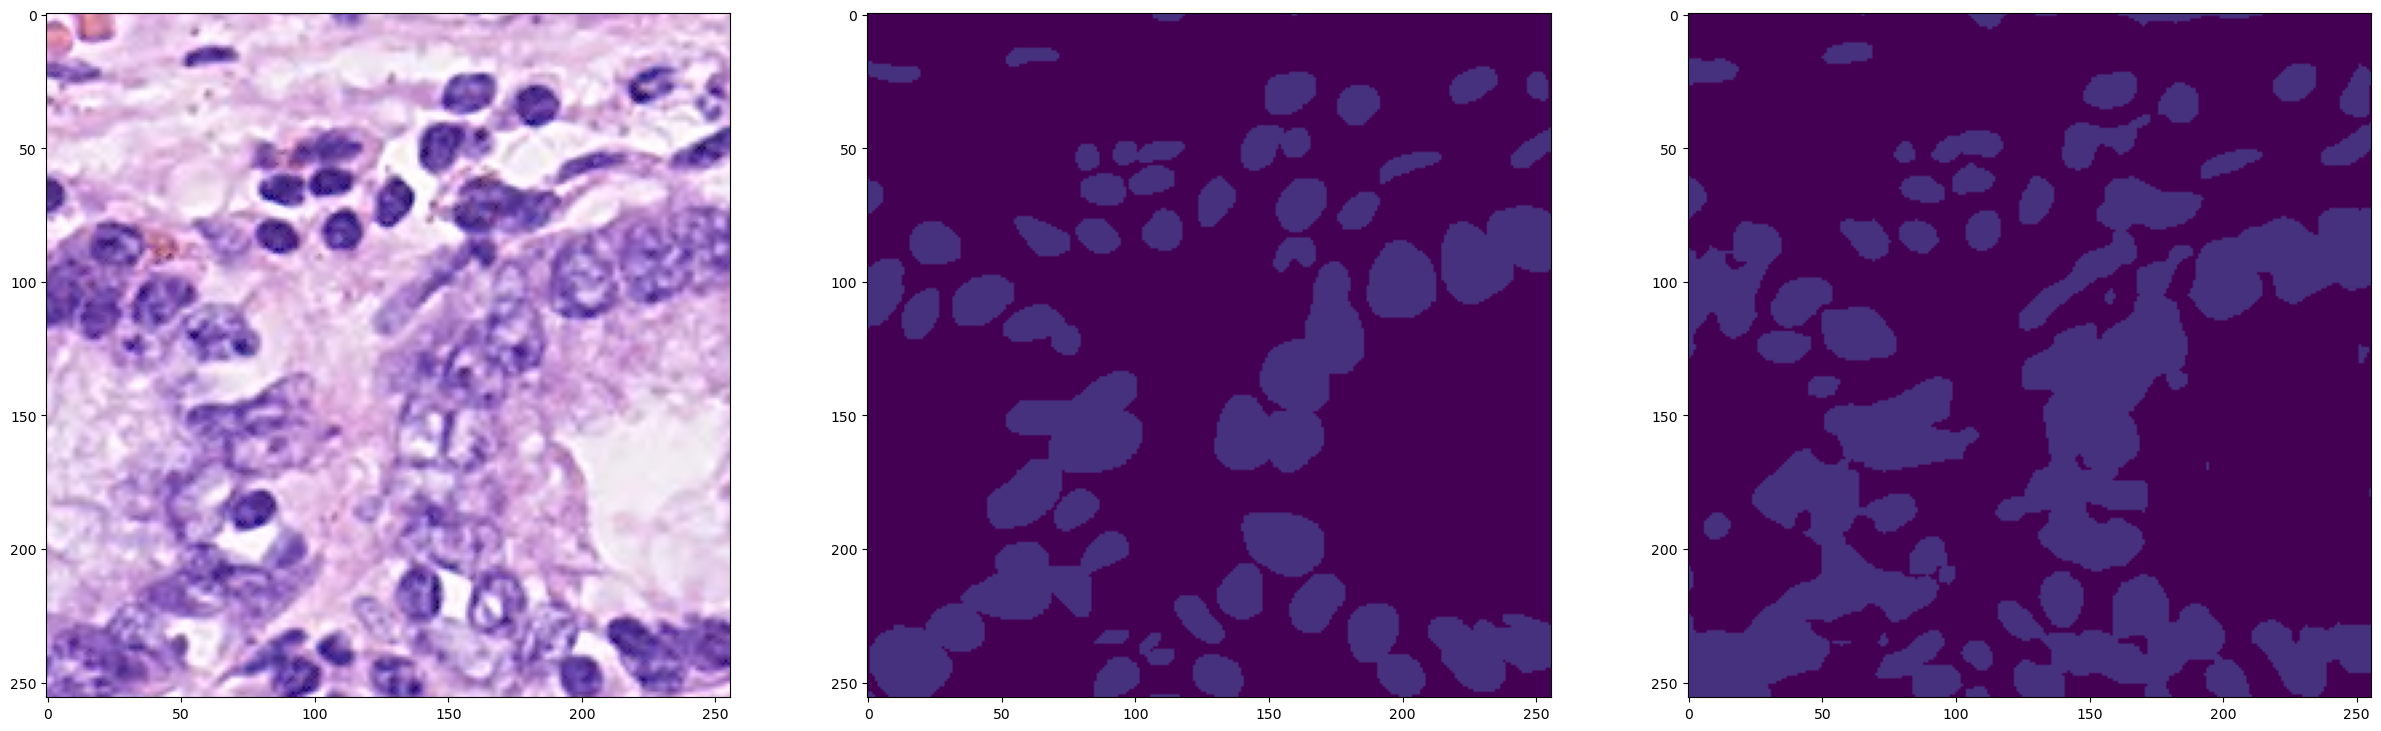

In [ ]:
test_prob = test_logit.sigmoid()
test_seg = torch.argmax(test_prob, dim = 1)
fig, axes = plt.subplots(1,3, figsize = (30,10))
axes[0].imshow(test_im[0].detach().cpu().numpy().transpose(1,2,0))
axes[1].imshow(test_set[index]['gt'],vmax = 7, vmin = 0)
axes[2].imshow(test_seg[0].detach().cpu().numpy(),vmax = 7, vmin = 0)

#### 结果是只有v3是正常的，意味着只有第二个loss是有效的，要对第一、三个loss进行排查